In [1]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

In [2]:
np.random.seed(783947328)

In [3]:
if not os.path.isdir("data"):
    os.mkdir("data")

Want array’s of  [list of particle 4-vectors(pt, mass, eta, phi), z_leading, theta] to feed into RNN or 1D CNN.

In [4]:
addPerturbation = True

In [5]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

In [6]:
def makeFourVectors(n_events = 10, n_particles = 5, isSignal = False, overlap = 0):
    labels = np.zeros(shape=(n_events,2))
    
    zloc = 0.5
    theta_loc = 0.2
    tau_loc = 0.4
    tau_loc2 = 0.3
    pt_factor = 1.
    if(addPerturbation):
        zloc = 0.5
        theta_loc = 0.1
        tau_loc = 0.4
        tau_loc2 = 0.3
        pt_factor = 0.5
    
        # create input variables
    if isSignal:
        if (overlap==0):
            theta = np.random.normal(loc=theta_loc, scale=0.02, size=n_events) # signal_d
            z = np.random.normal(loc=zloc, scale=0.02, size=n_events) #signal_z 
            tau = np.random.exponential(scale=0.04, size=n_events)  # signal_tau
            tautwo = np.random.exponential(scale=0.4, size=n_events)
        elif(overlap==1):
            theta = np.random.normal(loc=theta_loc, scale=0.03, size=n_events) # signal_d_littleoverlap
            z = np.random.normal(loc=zloc, scale=0.09, size=n_events) #signal_z_littleoverlap
            tau = np.random.exponential(scale=0.14, size=n_events)# signal_tau_littleoverlap
            tautwo = np.random.exponential(scale=0.08, size=n_events)
        elif(overlap==2):
            theta = np.random.normal(loc=theta_loc, scale=0.05, size=n_events) # signal_d_overlap
            z = np.random.normal(loc=zloc, scale=0.12, size=n_events) #signal_z_overlap
            tau = np.random.exponential(scale=0.2, size=n_events) # signal_tau_overlap
            tautwo = np.random.exponential(scale=0.1, size=n_events)
        pt = np.random.exponential(scale = 1/0.01, size = (n_events, n_particles))*pt_factor
        mass = 0.936*np.random.normal(loc = 39.5, scale = 18.3, size = (n_events,n_particles))
        eta = 1.1*np.random.normal(loc = 0.0, scale = 1.4, size = (n_events,n_particles))
        phi = np.random.uniform(-3.14,3.14,(n_events, n_particles))
        labels[:,1]=1
    else:
        if (overlap==0):
            theta = np.random.exponential(scale=0.02, size=n_events) # bkg_d
            z = np.random.exponential(scale=0.02, size=n_events) #bkg_z
            tau = np.random.exponential(scale=0.02, size=n_events) # bkg_b
            tautwo = np.random.exponential(scale=0.02, size=n_events)
        elif(overlap==1):
            theta = np.random.exponential(scale=0.03, size=n_events) # bkg_d_littleoverlap
            z = np.random.exponential(scale=0.1, size=n_events) #bkg_z_olittleverlap
            tau = np.random.exponential(scale=0.07, size=n_events) # bkg_b_olittleverlap
            tautwo = np.random.exponential(scale=0.04, size=n_events)
        elif(overlap==2):
            theta = np.random.exponential(scale=0.05, size=n_events) # bkg_d_overlap
            z = np.random.exponential(scale=0.15, size=n_events) #bkg_z_overlap
            tau = np.random.exponential(scale=0.1, size=n_events) # bkg_b_overlap
            tautwo = np.random.exponential(scale=0.05, size=n_events)
        pt = np.random.exponential(scale=1/0.002675, size = (n_events, n_particles))
        mass = np.random.exponential(scale=1/0.011082, size = (n_events, n_particles))
        eta = 1.008*np.random.normal(loc = 0.001913, scale = 1.811, size = (n_events, n_particles))
        phi = np.random.uniform(-3.14,3.14,size = (n_events, n_particles))
        labels[:,0]=1
        
        
    
    # masking z to ensure z<1.0
    z = np.where(z<1.0, z, z%1) #signal_z   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    
    mass = np.where(mass>0., mass, mass+20.)
    
    z = np.repeat(z, n_particles).reshape(n_events, n_particles)
    # masking theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_events, n_particles)
    
    # masking tau to ensure tau<0.7
    tau = np.where(tau<0.5, tau, tau%0.7)
    tau = np.repeat(tau, n_particles).reshape(n_events, n_particles)
    
    # masking tau to ensure tau<0.6
    tautwo = np.where(tautwo<0.5, tautwo, tautwo%0.6)
    tautwo = np.repeat(tautwo, n_particles).reshape(n_events, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_events), z)
    particles2 = np.multiply(partition_exp(n_particles, n_events), (1-z))
    
    
    # one jet has two subjets 
    radii = np.random.uniform(0.25,0.5 ,size = (n_events,2))
    radii1 = np.array([np.multiply(np.ones(shape = int(n_particles/2)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = int(n_particles/2)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_events, int(n_particles/2))) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_events, int(n_particles/2))) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_events, int(n_particles/2))) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_events, int(n_particles/2))) # angular
    
    z = z.reshape(n_events,n_particles)
    theta = theta.reshape(n_events,n_particles)
    tau = tau.reshape(n_events,n_particles)
    tautwo = tautwo.reshape(n_events,n_particles)
    radii = np.concatenate((radii1, radii2), axis = 1)
    return pt, eta, mass, phi, radii, z, theta, tau, tautwo, labels

Load some pythia data and fit to get idea of signal vs. background distribution to make a nice toy model

In [7]:
n_events = 10000
n_particles = 10
tic = time.perf_counter()
isSignal1 = True
overlap = 1
pt1, eta1, mass1, phi1, radii1, z1, theta1, tau1, tautwo1, labels1 = makeFourVectors(n_events, n_particles, isSignal1, overlap)
features1 = [pt1, eta1, mass1, phi1, radii1, z1, theta1, tau1, tautwo1]
print(pt1.shape, mass1.shape, phi1.shape, radii1.shape, z1.shape, theta1.shape,tau1.shape, tautwo1.shape, labels1.shape)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )

(10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 10) (10000, 2)
Processing Time is  0.30649334099996395 seconds for  10000  samples.


In [8]:
tic = time.perf_counter()
isSignal2 = False
pt2, eta2, mass2, phi2, radii2, z2, theta2, tau2, tautwo2, labels2= makeFourVectors(n_events, n_particles, isSignal2, overlap)
features2 = [pt2, eta2, mass2, phi2, radii2, z2, theta2, tau2, tautwo2]
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )

Processing Time is  0.29695186200001444 seconds for  10000  samples.


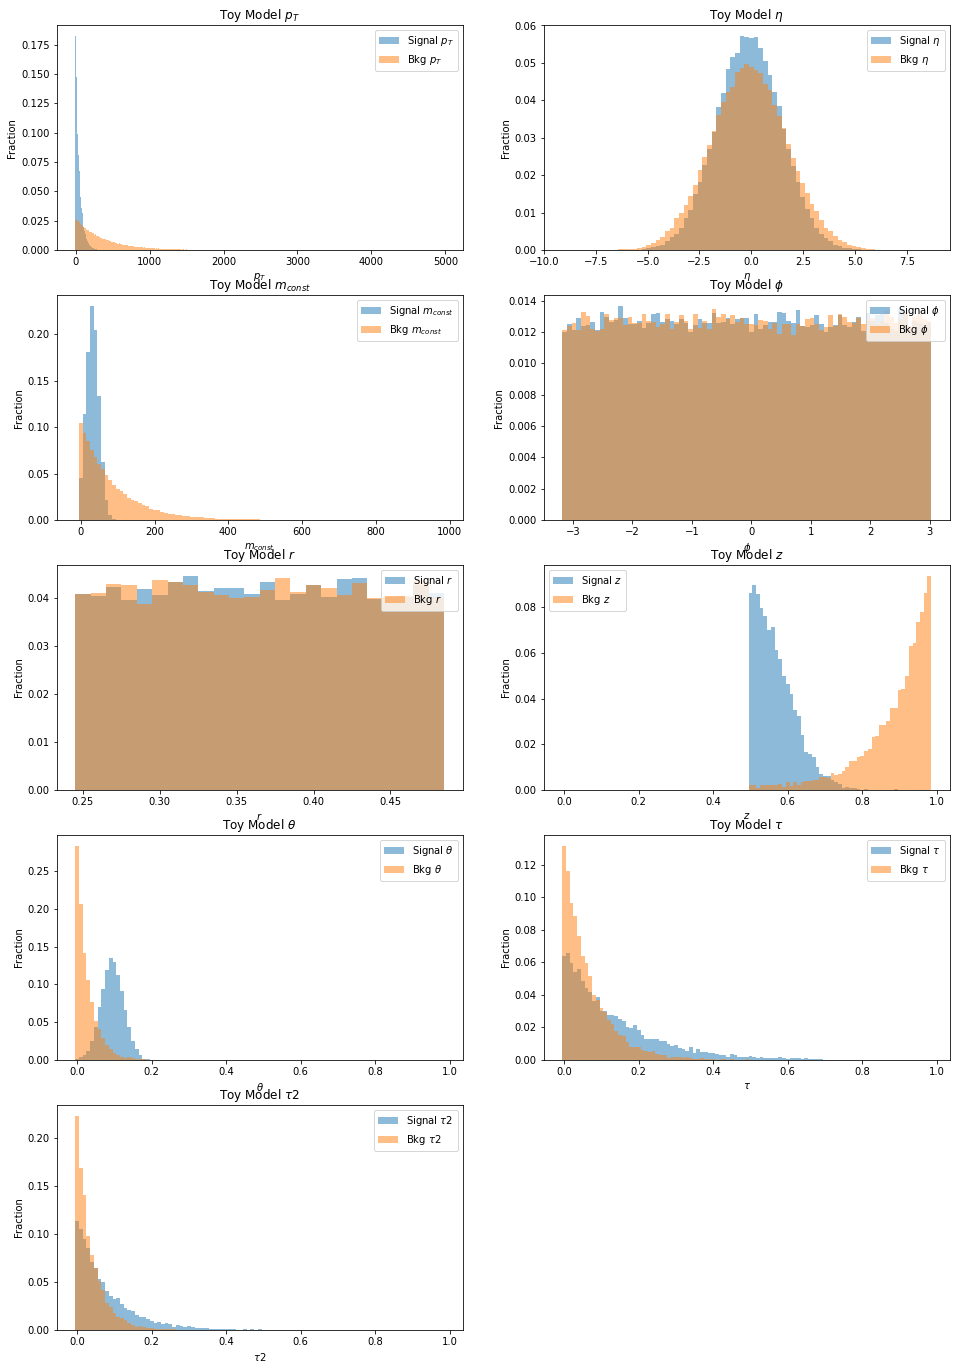

In [9]:
names = [r'$p_T$', r'$\eta$', r'$m_{const}$', r'$\phi$', r'$r$', r'$z$', r'$\theta$', r'$\tau$',r'$\tau$2' ]
ptbin = np.arange(0,5000, 10)
etabin = np.arange(-9, 9, 9/40)
mbin = np.arange(-10,1000,10)
phibin = np.arange(-np.pi, np.pi, np.pi/40)
thetabin = np.arange(0, 1, 0.01)
zbin = np.arange(0,1,0.01)
rbin = np.arange(0.25,0.5, 0.01)
taubin = np.arange(0,1,0.01)
tautwobin = np.arange(0,1,0.01)
bins = [ptbin, etabin, mbin, phibin, rbin, zbin, thetabin, taubin, tautwobin]
plt.figure(figsize = (16,24))
for i in np.arange(len(features1)):
    plt.subplot(int(len(features1)/2)+1,2,(i+1))
    hist1, bins1 = np.histogram(features1[i], bins=bins[i])
    hist2, bins2 = np.histogram(features2[i], bins=bins1)
    plt.bar(bins1[:-1], hist1/(np.sum(hist1)), width=np.diff(bins1), alpha = 0.5, label = "Signal " + names[i])
    plt.bar(bins2[:-1], hist2/(np.sum(hist2)), width=np.diff(bins2), alpha = 0.5, label = "Bkg "+names[i])
    plt.xlabel(names[i])
    plt.ylabel("Fraction")
    legend = plt.legend()
    plt.title("Toy Model "+names[i])

In [10]:
tic = time.perf_counter()
isSignal3 = True
pt3, eta3, mass3, phi3, radii3, z3, theta3, tau3, tautwo3, labels3= makeFourVectors(n_events, n_particles, isSignal3, overlap)
toc = time.perf_counter()
fourvectors3 = np.array([pt3, eta3, mass3, phi3])
fourvectors3 = fourvectors3.reshape(n_events, n_particles, 4)
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )
np.savez('data/dummyvectors_sgn_test', pt = pt3, eta = eta3, phi = phi3, mass = mass3, radiilab = radii3, zlab = z3, thetalab = theta3, taulab = tau3, tautwolab = tautwo3, labels = labels3)

Processing Time is  0.2881976889999578 seconds for  10000  samples.


In [11]:
tic = time.perf_counter()
isSignal4 = False
pt4, eta4, mass4, phi4, radii4, z4, theta4, tau4, tautwo4, labels4= makeFourVectors(n_events, n_particles, isSignal4, overlap)
toc = time.perf_counter()
fourvectors4 = np.array([pt4, eta4, mass4, phi4])
fourvectors4 = fourvectors4.reshape(n_events, n_particles, 4)
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )
np.savez('data/dummyvectors_bkg_test', pt = pt4, eta = eta4, phi = phi4, mass = mass4, radiilab = radii4, zlab = z4, thetalab = theta4, taulab = tau4 , tautwolab = tautwo4, labels = labels4)

Processing Time is  0.37323610900000403 seconds for  10000  samples.


### Concatenate signal and bg together, shuffle, and save files

In [12]:
trainlabels = np.concatenate((labels1,labels2),axis=0)
n_train = len(trainlabels)
train_pt = np.concatenate((pt1, pt2), axis = 0)
batch = np.size(train_pt, 1)
train_pt = train_pt.reshape(n_train, batch, 1)
train_eta = np.concatenate((eta1, eta2), axis = 0).reshape(n_train, batch, 1)
train_phi = np.concatenate((phi1, phi2), axis = 0).reshape(n_train, batch, 1)
train_mass = np.concatenate((mass1, mass2), axis = 0).reshape(n_train, batch, 1)
train_r = np.concatenate((radii1, radii2), axis = 0)
train_theta = np.concatenate((theta1, theta2), axis = 0)
train_z = np.concatenate((z1, z2), axis = 0)
train_tau = np.concatenate((tau1, tau2), axis = 0)
train_tautwo = np.concatenate((tautwo1, tautwo2), axis = 0)
train_labels = trainlabels.reshape(n_train, 2)
# testing data
testlabels = np.concatenate((labels3, labels4),axis=0)
n_test = len(testlabels)
test_pt = np.concatenate((pt3, pt4), axis = 0)
batch = np.size(test_pt, 1)
test_pt = test_pt.reshape(n_test, batch, 1)
test_eta = np.concatenate((eta3, eta4), axis = 0).reshape(n_test, batch, 1)
test_phi = np.concatenate((phi3, phi4), axis = 0).reshape(n_test, batch, 1)
test_mass = np.concatenate((mass3, mass4), axis = 0).reshape(n_test, batch, 1)
test_r = np.concatenate((radii3, radii4), axis = 0)
test_theta = np.concatenate((theta3, theta4), axis = 0)
test_z = np.concatenate((z3, z4), axis = 0)
test_tau = np.concatenate((tau3, tau4), axis = 0)
test_tautwo = np.concatenate((tautwo3, tautwo4), axis = 0)
test_labels = testlabels.reshape(int(n_test), 2)


In [13]:
# get indices
train_ind = np.arange(len(train_labels[:,0]))
test_ind = np.arange(len(test_labels[:,0]))

# shuffle indices
np.random.shuffle(train_ind)
np.random.shuffle(test_ind)



train_features = [train_pt, train_eta, train_phi, train_mass, train_theta, train_r, train_z, train_tau, train_tautwo, train_labels]
test_features = [test_pt, test_eta, test_phi, test_mass, test_theta, test_r, test_z, train_tau, train_tautwo, test_labels]
for i in np.arange(len(train_features)):
    train_features[i] = train_features[i][train_ind]
    test_features[i] = test_features[i][test_ind]

    

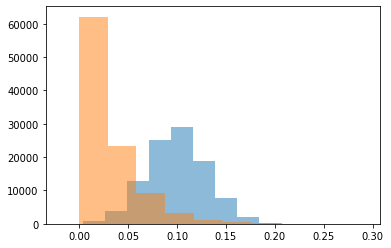

In [14]:
sig = (train_features[-1][:,0]==0)
bkg = (train_features[-1][:,0]==1)

plt.hist(train_features[4][sig].flatten(), alpha=0.5)
plt.hist(train_features[4][bkg].flatten(), alpha=0.5)
plt.show()

In [15]:

ext = ''
if(addPerturbation):
    ext='_perturb'

filename_train = 'data/jetConstTrain_overlap'+ext
filename_test = 'data/jetConstTest_overlap'+ext

np.savez(filename_train, pt = train_features[0], eta = train_features[1], phi = train_features[2],
         mass = train_features[3], theta = train_features[4], radii = train_features[5],
         z = train_features[6], tau1 = train_features[7], tau2 = train_features[8],labels = train_features[9])

np.savez(filename_test, pt = test_features[0], eta = test_features[1], phi = test_features[2], mass = test_features[3],
         theta = test_features[4], radii = test_features[5], z = test_features[6], tau1 = test_features[7],
         tau2 = test_features[8], labels = test_features[9])

print('saving '+filename_train+'.npz')
print('saving '+filename_test+'.npz')

saving data/jetConstTrain_overlap_perturb.npz
saving data/jetConstTest_overlap_perturb.npz
